<div style="background-color: #e0f7fa; border-radius: 10px; width:90%;">
    <h2 style="color: #00796b;">Fenicsx Code</h2>
</div> 

In [5]:
# import modules

import numpy as np
from dolfinx import mesh, fem
from mpi4py import MPI
from petsc4py import PETSc
import ufl
import dolfinx.fem.petsc
import dolfinx.io
from basix.ufl import element, mixed_element
from dolfinx.fem import (Function, dirichletbc, form, functionspace,
                         locate_dofs_topological, Constant)
from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
from ufl import div, dx, grad, inner, ds, SpatialCoordinate
import matplotlib.pyplot as plt
from dolfinx import plot
import time
import pyvista
from dolfinx.plot import vtk_mesh
import warnings
warnings.filterwarnings("ignore")
from dolfinx.io import VTKFile

#######################################################################

# Create functions for boundary conditions

def Dirichlet_boundary(x):
    return np.logical_or(np.logical_or(np.isclose(x[0], 0.0), np.isclose(x[0], 1.0)),np.logical_or(np.isclose(x[1], 0.0), np.isclose(x[1], 1.0)))

def u_expression(x):
    return np.stack((np.zeros(x.shape[1]), np.zeros(x.shape[1])))

#######################################################################

# Create function to solve the problem

def mixed_direct(TH, msh):

    # Define function spaces
    W = functionspace(msh, TH)
    W0, _ = W.sub(0).collapse()
    W1, W1_to_W = W.sub(1).collapse()
    u_d = Function(W0)

    #######################################################################

   # No-slip boundary condition for velocity 
    u_d.interpolate(u_expression)
    facets = locate_entities_boundary(msh, 1, Dirichlet_boundary)
    dofs = locate_dofs_topological((W.sub(0), W0), 1, facets)
    bc0 = dirichletbc(u_d, dofs, W.sub(0))
    bcs = [bc0]

    #######################################################################
    
    # Define the exacte solutions u_ex et p_ex for defining the source term "f"
    def u_ex(x):
        return (-256*x[1]*(x[1]-1)*(2*x[1]-1)*(x[0]**2)*(x[0]-1)**2, 256*x[0]*(x[0]-1) *
                                   (2*x[0]-1)*(x[1]**2)*(x[1]-1)**2)
    def p_ex(x):
        return (x[0]-0.5)*(x[1]-0.5)
    
    #######################################################################
    
    # Define variational problem
    (u, p) = ufl.TrialFunctions(W)
    (v, q) = ufl.TestFunctions(W)
    x = ufl.SpatialCoordinate(msh)
    n = ufl.FacetNormal(msh)
    mu = 1
    u_exact = ufl.as_vector((u_ex(x)))
    f = -mu*div(grad(u_exact)) + grad(p_ex(x))
    # g = mu * ufl.dot(ufl.grad(u_exact), n) - p_ex(x) * n
    a = form(mu*(inner(grad(u), grad(v)) - inner(p, div(v)) + inner(div(u), q)) * dx)
    L = form(inner(f, v) * dx)

    #######################################################################
    
    # Assemble LHS matrix and RHS vector
    A = fem.petsc.assemble_matrix(a, bcs=bcs)
    A.assemble()
    b = fem.petsc.assemble_vector(L)
    fem.petsc.apply_lifting(b, [a], bcs=[bcs])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)

    #######################################################################

    # Set Dirichlet boundary condition values in the RHS
    fem.petsc.set_bc(b, bcs)

    #######################################################################

    # Create and configure solver

    ksp = PETSc.KSP().create(msh.comm)
    ksp.setOperators(A)
    ksp.setType("preonly")
    
    #######################################################################

    # Handle pressure nullspace
    
    null_vec = dolfinx.fem.Function(W)
    null_vec.x.array[W1_to_W] = 1.0
    dolfinx.la.orthonormalize([null_vec.vector])
    nsp = PETSc.NullSpace().create(vectors=[null_vec.vector])
    A.setNearNullSpace(nsp)
    A.setNullSpace(nsp)

    pc = ksp.getPC()
    pc.setType("lu")
    pc.setFactorSolverType("mumps")

    #######################################################################

    # Compute the solution
    U = Function(W)
    try:
        ksp.solve(b, U.vector)
    except PETSc.Error as e:
        if e.ierr == 92:
            print("The required PETSc solver/preconditioner is not available. Exiting.")
            print(e)
            exit(0)
        else:
            raise e
    ksp.solve(b, U.vector)

    #######################################################################

    # Split the mixed solution and collapse
    
    u, p = U.sub(0).collapse(), U.sub(1).collapse()
    u.x.scatter_forward()
    p.x.scatter_forward()

    # Normalize p_ex over unit square
    
    p_avg = W.mesh.comm.allreduce(
        fem.assemble_scalar(fem.form(p*dx)), op=MPI.SUM)
    p.x.array[:] -= p_avg
    return u, p

<div style="background-color: #e0f7fa; border-radius: 10px; width:90%;">
    <h2 style="color: #00796b;">Convergence Study</h2>
</div>

In [21]:
# Errors and convergence rates for velocity and pressure
# ======================================================


# Creat function to compute errors 

def compute_errors(u, p, msh, TH):
    W = functionspace(msh, TH)
    W0, _ = W.sub(0).collapse()
    W1, _ = W.sub(1).collapse()

    u_exact = Function(W0)
    u_exact.interpolate(lambda x: (-256*x[1]*(x[1]-1)*(2*x[1]-1)*(x[0]**2)*(x[0]-1)**2, 256*x[0]*(x[0]-1) *
                                   (2*x[0]-1)*(x[1]**2)*(x[1]-1)**2))
    p_exact = Function(W1)
    p_exact.interpolate(lambda x: (x[0]-0.5)*(x[1]-0.5))

    # Compute the L2 error for the velocity

    Forme_u_L2 = fem.form(ufl.inner(u - u_exact, u - u_exact) * ufl.dx)
    assb_u_L2= fem.assemble_scalar(Forme_u_L2)
    error_u_L2= np.sqrt(msh.comm.allreduce(assb_u_L2, op=MPI.SUM))

    # Compute the H1 error for the velocity

    square_norme_L2 = inner(u - u_exact, u - u_exact) * ufl.dx
    squared_semi_norme_L2 = inner(grad(u - u_exact), grad(u - u_exact)) * ufl.dx
    squared_norme_H1 = fem.form(square_norme_L2+squared_semi_norme_L2)
    assb_u_H1 = fem.assemble_scalar(squared_norme_H1)
    error_u_H1 = np.sqrt(msh.comm.allreduce(assb_u_H1, op=MPI.SUM))

    # Compute the L2 error for the pressure

    Forme_p_L2= fem.form(ufl.inner(p - p_exact, p - p_exact) * ufl.dx)
    assb_p_L2= fem.assemble_scalar(Forme_p_L2)
    error_p_L2= np.sqrt(msh.comm.allreduce(assb_p_L2, op=MPI.SUM))

    return error_u_L2, error_u_H1, error_p_L2


L2_u = []
L2_p = []
H1_u = []
h = []
time_values=[]
num_elements_list = [4, 8, 16, 32, 64, 128]
for i in num_elements_list:

    # Start the timer
    start_time = time.time()

    # Compute u and p for each mesh step 1/i over the unite square
    msh = create_rectangle(MPI.COMM_WORLD, ((0.0, 0.0), (1.0, 1.0)), (i, i), CellType.triangle)
    P2 = element("Lagrange", msh.basix_cell(), 2, shape=(msh.geometry.dim,))
    P1 = element("Lagrange", msh.basix_cell(), 1)
    TH = mixed_element([P2, P1])
    u, p = mixed_direct(TH, msh)

    error_u_L2, error_u_H1, error_p_L2 = compute_errors(u, p, msh, TH)
    L2_u.append(error_u_L2) # to create vector that contains all L2 errors for the velocity
    L2_p.append(error_p_L2) # to create vector that contains all H1 errors for the velocity
    H1_u.append(error_u_H1) # to create vector that contains all L2 errors for the pressure
    h.append(1. / i) # to create vector that includes all mesh steps

    V = fem.functionspace(msh, P2)
    Q = fem.functionspace(msh, P1)

    # Display the number of local dofs
    num_dofs_local = (V.dofmap.index_map.size_local) * V.dofmap.index_map_bs

    # Display the number of glaobal dofs for pressure and velocity
    num_dofs_global_vel= V.dofmap.index_map.size_global * V.dofmap.index_map_bs
    num_dofs_global_press = Q.dofmap.index_map.size_global * Q.dofmap.index_map_bs

    # Stop the timer
    end_time = time.time()

    # Compute the elapsed time
    elapsed_time = np.round(end_time - start_time,5)
    time_values.append(elapsed_time) # to create vector that includes elapsed time for each mesh step

    # Display errors, nbre of dofs and elapsed time
    print(f"error_L2_vel : {error_u_L2:e} | error_H1_vel : {error_u_H1:e} | error_L2_press : {error_p_L2:e} | Dofs_vel : {num_dofs_global_vel} | Dofs_press : {num_dofs_global_press} | elapsed_time : {elapsed_time} secondes")

# Display Convergence rates 
    
vel_rates_L2=np.log(np.array(L2_u[1:]) / np.array(L2_u[:-1]))/np.log(np.array(h[1:]) / np.array(h[:-1]))
velocity_rates_L2 = ["{:.3f}".format(x) for x in vel_rates_L2]
comm = u.function_space.mesh.comm
if comm.rank == 0:
    print(f"Convergence_rate_L2_vel : {velocity_rates_L2}")

#--------------------------------
vel_rates_H1=np.log(np.array(H1_u[1:]) / np.array(H1_u[:-1]))/np.log(np.array(h[1:]) / np.array(h[:-1]))
velocity_rates_H1 = ["{:.3f}".format(x) for x in vel_rates_H1]
comm = u.function_space.mesh.comm
if comm.rank == 0:
    print(f"Convergence_rate_H1_vel : {velocity_rates_H1}")

#-----------------------------------------
pr_rates_L2=np.log(np.array(L2_p[1:]) / np.array(L2_p[:-1]))/np.log(np.array(h[1:]) / np.array(h[:-1]))
press_rates_L2 = ["{:.3f}".format(x) for x in pr_rates_L2]
comm = u.function_space.mesh.comm
if comm.rank == 0:
     print(f"Convergence_rate_L2_press : {press_rates_L2}")

error_L2_vel : 2.050932e-02 | error_H1_vel : 2.877525e-01 | error_L2_press : 3.382412e-01 | Dofs_vel : 162 | Dofs_press : 25 | elapsed_time : 0.05991 secondes
error_L2_vel : 1.693377e-03 | error_H1_vel : 4.722530e-02 | error_L2_press : 3.450509e-02 | Dofs_vel : 578 | Dofs_press : 81 | elapsed_time : 0.03922 secondes
error_L2_vel : 1.135779e-04 | error_H1_vel : 6.797380e-03 | error_L2_press : 3.076076e-03 | Dofs_vel : 2178 | Dofs_press : 289 | elapsed_time : 0.09756 secondes
error_L2_vel : 7.233455e-06 | error_H1_vel : 9.140147e-04 | error_L2_press : 2.739968e-04 | Dofs_vel : 8450 | Dofs_press : 1089 | elapsed_time : 0.25828 secondes
error_L2_vel : 4.541401e-07 | error_H1_vel : 1.185624e-04 | error_L2_press : 3.021884e-05 | Dofs_vel : 33282 | Dofs_press : 4225 | elapsed_time : 1.59008 secondes
error_L2_vel : 2.840698e-08 | error_H1_vel : 1.509885e-05 | error_L2_press : 5.437914e-06 | Dofs_vel : 132098 | Dofs_press : 16641 | elapsed_time : 5.47858 secondes
Convergence_rate_L2_vel : ['3.5

In [27]:

x = np.log(np.array(h))
y_L2_press = np.log(np.array(L2_p))
y_L2_vel=np.log(np.array(L2_u))
y_H1_vel=np.log(np.array(H1_u))

# Fitting a line (polynomial of degree 1) to the data
coeff_L2_press = np.polyfit(x, y_L2_press, 1)
coeff_L2_vel = np.polyfit(x, y_L2_vel, 1)
coeff_H1_vel= np.polyfit(x, y_H1_vel, 1)

# The degree 1 coefficient corresponds to the slope
slope_L2_press = np.around(coeff_L2_press[0],2)
slope_L2_vel = np.around(coeff_L2_vel[0],2)
slope_H1_vel = np.around(coeff_H1_vel[0],2)

# Display the slopes
print("Slope for L2 pressure :", slope_L2_press)
print("Slope for L2 vel :", slope_L2_vel)
print("Slope for H1 vel :", slope_H1_vel)

Slope for L2 pressure : 3.25
Slope for L2 vel : 3.91
Slope for H1 vel : 2.85


<div style="background-color: #e0f7fa; border-radius: 10px; width:90%;">
    <h2 style="color: #00796b;">Convergence curves for velocity and pressure</h2>
</div>

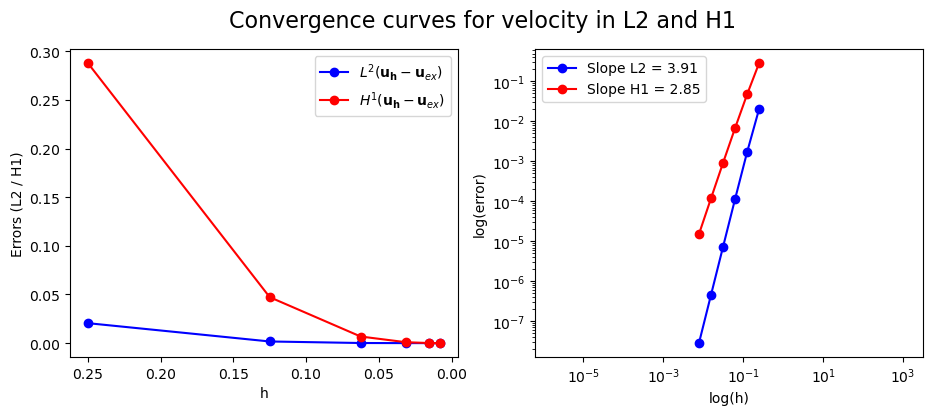

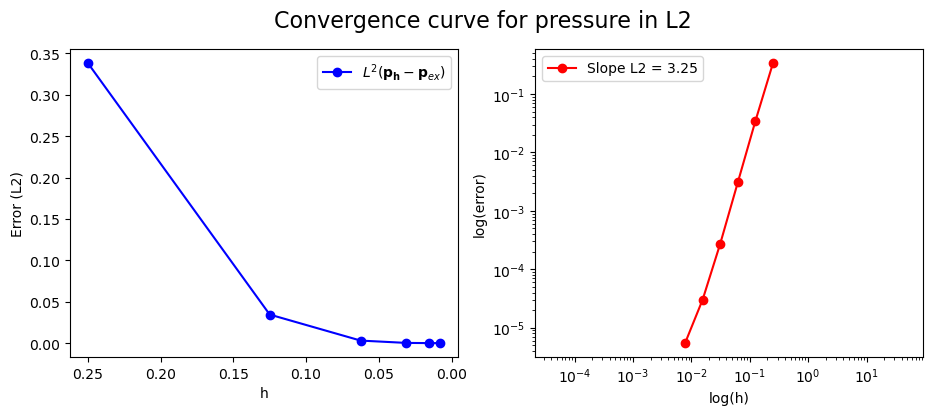

In [35]:
# Convergence curve for the velocity
fig = plt.figure(figsize=(11, 4))

# Plot for velocity error in L2 and H1 norms
plt.subplot(1, 2, 1)
plt.plot(h, L2_u, "bo-", label=r"$L^2(\mathbf{u_h}-\mathbf{u}_{ex})$")
plt.plot(h, H1_u, "ro-", label=r"$H^1(\mathbf{u_h}-\mathbf{u}_{ex})$")

# Define legend for the first subplot
legend_labels = [r"$L^2(\mathbf{u_h}-\mathbf{u}_{ex})$", 
                 r"$H^1(\mathbf{u_h}-\mathbf{u}_{ex})$"]
plt.legend(legend_labels, loc='best')

# Reverse the x-axis for mesh size h (smaller h on the right)
plt.xlim(plt.xlim()[::-1])
plt.xlabel("h")
plt.ylabel("Errors (L2 / H1)")

# Second subplot with slopes
plt.subplot(1, 2, 2)
plt.plot(h, L2_u, "bo-", label=r"$L^2(\mathbf{u_h}-\mathbf{u}_{ex})$")
plt.plot(h, H1_u, "ro-", label=r"$H^1(\mathbf{u_h}-\mathbf{u}_{ex})$")

# Display slopes in the legend
legend_labels = [
    rf"Slope L2 = {slope_L2_vel:.2f}",
    rf"Slope H1 = {slope_H1_vel:.2f}"
]
plt.legend(legend_labels, loc='best')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("log(h)")
plt.ylabel("log(error)")
plt.axis("equal")

# Save the figure for velocity convergence
plt.savefig("u_rate.png")

# Main title for the figure
fig.suptitle('Convergence curves for velocity in L2 and H1', fontsize=16)

# Convergence curve for the pressure
fig = plt.figure(figsize=(11, 4))

# First subplot for pressure error in L2 norm
plt.subplot(1, 2, 1)
plt.plot(h, L2_p, "bo-", label=r"$L^2(\mathbf{p_h}-\mathbf{p}_{ex})$")
plt.legend(loc='best')

# Reverse the x-axis for mesh size h
plt.xlim(plt.xlim()[::-1])
plt.xlabel("h")
plt.ylabel("Error (L2)")

# Second subplot with slope for pressure
plt.subplot(1, 2, 2)
plt.plot(h, L2_p, "ro-", label=rf"Slope L2 = {slope_L2_press:.2f}")
plt.legend(loc='best')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("log(h)")
plt.ylabel("log(error)")
plt.axis("equal")

# Save the figure for pressure convergence
plt.savefig("p_rate.png")

# Main title for the pressure figure
fig.suptitle('Convergence curve for pressure in L2', fontsize=16)

plt.show()  # Display the plots


<div style="background-color: #e0f7fa; border-radius: 10px; width:90%;">
    <h2 style="color: #00796b;">Visualizing solutions</h2>
</div>

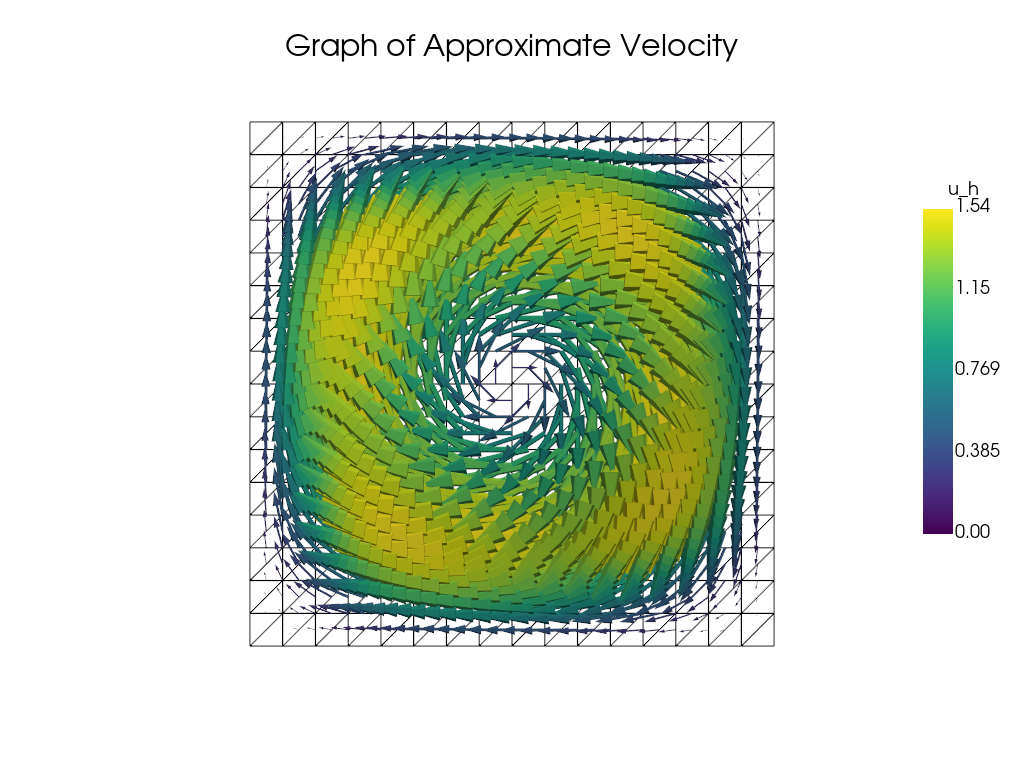

In [54]:
#===================================================================
# Visualization of the approximate velocity
#===================================================================

pyvista.start_xvfb()

if __name__ == "__main__":
    # Create a rectangular mesh using the MPI communicator
    msh = create_rectangle(MPI.COMM_WORLD, ((0.0, 0.0), (1.0, 1.0)), (16, 16), CellType.triangle)
    
    # Define Lagrange elements for the velocity (P2) and pressure (P1)
    P2 = element("Lagrange", msh.basix_cell(), 2, shape=(msh.geometry.dim,))
    P1 = element("Lagrange", msh.basix_cell(), 1)
    
    # Create a function space for the velocity
    V = fem.functionspace(msh, P2)
    
    # Create a mixed element for velocity and pressure
    TH = mixed_element([P2, P1])
    
    # Solve for the mixed variables (u_h, p_h)
    u_h, p_h = mixed_direct(TH, msh)
    
    # Write the mesh and function for the velocity to a VTK file
    with VTKFile(msh.comm, "berkovier_velocity.pvd", "w") as file:
        file.write_mesh(msh)
        file.write_function([u_h._cpp_object])
    
    # Write the mesh and function for the pressure to a VTK file
    with VTKFile(msh.comm, "berkovier_pressure.pvd", "w") as file:
        file.write_mesh(msh)
        file.write_function([p_h._cpp_object])

# Obtain the topology, cell types, and geometry of the mesh
topology, cell_types, geometry = vtk_mesh(u_h.function_space)

# Create an array to hold the values of the velocity
values = np.zeros((geometry.shape[0], 3), dtype=np.float64)
values[:, :len(u_h)] = u_h.x.array.real.reshape((geometry.shape[0], len(u_h)))

# Create a glyph point cloud to visualize the velocity
function_grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
function_grid["u_h"] = values
glyphs = function_grid.glyph(orient="u_h", factor=0.2)

# Create a PyVista grid for the mesh
grid = pyvista.UnstructuredGrid(*vtk_mesh(msh, msh.topology.dim))

# Plotting the graph with PyVista
plotter = pyvista.Plotter()
plotter.add_title("Graph of Approximate Velocity", font_size=12, color='k', font=None, shadow=False)
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(glyphs)
plotter.add_scalar_bar(vertical=True, title="u_h", position_x=0.9, position_y=0.3)
plotter.remove_scalar_bar(title="GlyphScale")
plotter.view_xy()

# Display the plot
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    fig_as_array = plotter.screenshot("num_velocity.png")


## Visualisation de la pression approchée

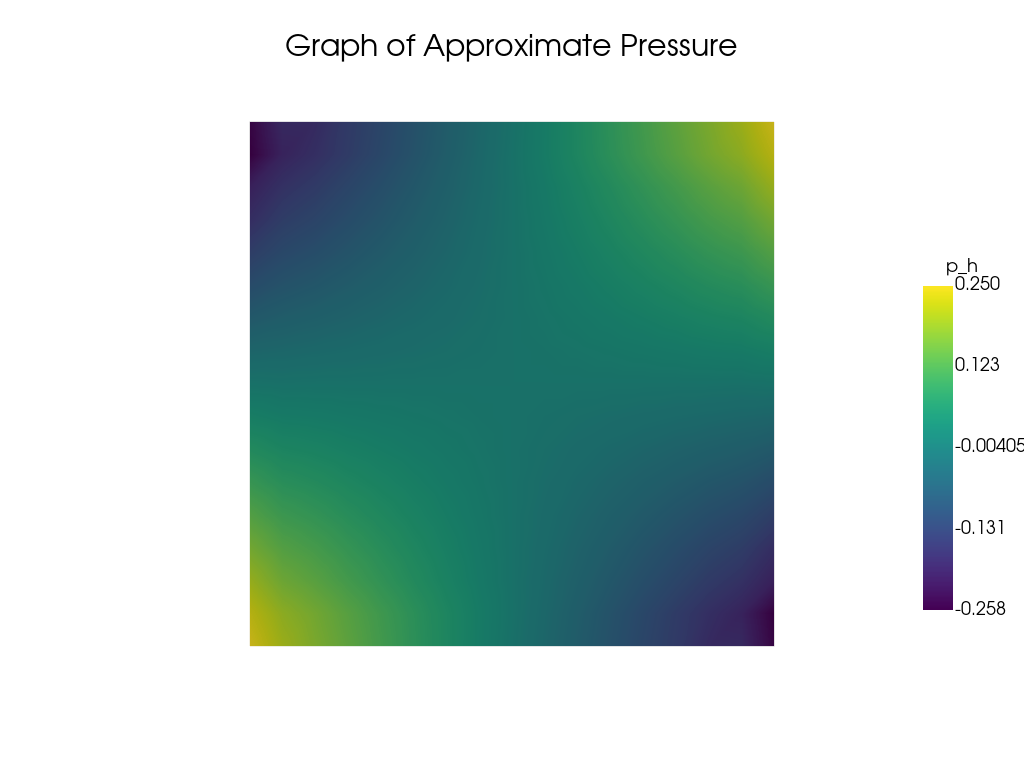

In [55]:

#===================================================================
# Visualization of the approximate pressure
#===================================================================

# Create an unstructured grid object for the pressure data
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(p_h.function_space)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)

# Add pressure data to the grid
u_grid.point_data["p_hh"] = p_h.x.array.real

# Set active scalars for visualization
u_grid.set_active_scalars("p_hh")

# Create a plotter for visualization
u_plotter = pyvista.Plotter()

# Add a title to the plotter
u_plotter.add_title("Graph of Approximate Pressure", font_size=12, color='k', font=None, shadow=False)

# Add the grid with pressure data to the plotter
u_plotter.add_mesh(u_grid, show_edges=False)

# Add a color bar for the scalars
u_plotter.add_scalar_bar(vertical=True, title="p_h", position_x=0.9, position_y=0.2)

# Remove the default color bar
u_plotter.remove_scalar_bar(title="p_hh")

# Adjust the view to an XY view
u_plotter.view_xy()

# Show the plotter or save the image if necessary
if not pyvista.OFF_SCREEN:
    u_plotter.show()
else:
    figure = u_plotter.screenshot("num_press.png")
